# Introduction: Hyperparameter Tuning using Grid and Random Search

In this notebook, we will explore two methods for hyperparameter tuning a machine learning model. [In contrast](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/) to model __parameters__ which are learned during training, model __hyperparameters__ are set by the data scientist ahead of training and control implementation aspects of the model. The weights learned during training of a linear regression model are parameters while the number of trees in a random forest is a model hyperparameter because this is set by the data scientist. Hyperparameters can be thought of as model settings. These settings need to be tuned for each problem because the best model hyperparameters for one particular dataset will __not be__ the best across all datasets. The process of [hyperparameter tuning (also called hyperparameter optimization)](https://en.wikipedia.org/wiki/Hyperparameter_optimization) means finding the combination of hyperparameter values for a machine learning model that performs the best - as measured on a validation dataset - for a problem. 

(__Quick Note__: a lot of data scientists use the terms _parameters_ and _hyperparameters_ interchangeably to refer to the model settings. While this is technically incorrect, it's pretty common practice and it's usually possible to tell when they are referring to parameters learned during training versus hyperparameters. I'll try to stick to using model hyperparameters or model settings and I'll  point out when I'm talking about a parameter that is learned during training. If you're still confused, [this article](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/) may help you out!)

__Additional Notebooks__ 

If you haven't checked out my other work on this problem, here is a complete list of the notebooks I have completed so far:

* [A Gentle Introduction](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)
* [Manual Feature Engineering Part One](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering)
* [Manual Feature Engineering Part Two](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2)
* [Introduction to Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics)
* [Advanced Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/tuning-automated-feature-engineering-exploratory)
* [Feature Selection](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
* [Intro to Model Tuning: Grid and Random Search](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)
* [Automated Model Tuning](https://www.kaggle.com/willkoehrsen/automated-model-tuning)

There are several approaches to hyperparameter tuning

1. __Manual__: select hyperparameters based on intuition/experience/guessing, train the model with the hyperparameters, and score on the validation data. Repeat process until you run out of patience or are satisfied with the results. 
2. __Grid Search__: set up a grid of hyperparameter values and for each combination, train a model and score on the validation data. In this approach, every single combination of hyperparameters values is tried which can be very inefficient!
3. __Random search__: set up a grid of hyperparameter values and select _random_ combinations to train the model and score. The number of search iterations is set based on time/resources. 
4. __Automated Hyperparameter Tuning__: use methods such as gradient descent, Bayesian Optimization, or evolutionary algorithms to conduct a guided search for the best hyperparameters.

(This [Wikipedia Article](https://en.wikipedia.org/wiki/Hyperparameter_optimization) provides a good high-level overview of tuning options with links for more details)

In this notebook, we will implement approaches 2 and 3 for a Gradient Boosting Machine Learning Model. In a future notebook, we will implement automated hyperparameter tuning using Bayesian optimization, specifically the Hyperopt library. If you want to get an idea of how automated hyperparameter tuning is done, check out [this article](https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a). 

## Model: Gradient Boosting Machine 

The [Gradient Boosting Machine (GBM)](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/) has recently emerged as one of the top machine learning models. The GBM is extremely effective on structured data - where the information is in rows and columns - and medium sized datasets - where there are at most a few million observations. We will focus on this model because it is currently the top performing method for most competitions on Kaggle and because the performance is highly dependent on the hyperparameter choices. The basics you need to know about the GBM are that it is an ensemble method that works by training many individual learners, almost always decision trees. However, unlike in a random forest where the trees are trained in __parallel__, in a GBM, the trees are trained __sequentially__ with each tree learning from the mistakes of the previous ones. The hundreds or thousands of weak learners are combined to make a single strong ensemble learner with the contributions of each individual learned during training using Gradient Descent (the weights of the individual trees would therefore be a model _parameter_). 

The GBM [has many hyperparameters to tune](http://lightgbm.readthedocs.io/en/latest/Parameters.html) that control both the overall ensemble (such as the learning rate) and the individual decision trees (such as the number of leaves in the tree or the maximum depth of the tree). It is difficult to know which combination of hyperparameters will work best based only on theory because there are complex interactions between hyperparameters. Hence the need for hyperparameter tuning: the only way to find the optimal hyperparameter values is to try many different combinations on a dataset!

We will use the implementation of the Gradient Boosting Machine in the [LightGBM library](http://lightgbm.readthedocs.io/en/latest/). This is a much faster (and some say more accurate) implementation than that available in Scikit-Learn.

For more details of the Gradient Boosting Machine (GBM), check out this [high-level blog post](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/), or this [in depth technical article.](https://brage.bibsys.no/xmlui/bitstream/handle/11250/2433761/16128_FULLTEXT.pdf) 

### Getting Started

With the necessary background out of the way, let's get started. For this notebook, we will work with a subset of the data consisting of 10000 rows. Hyperparameter tuning is extremely computationally expensive and working with the full dataset in a Kaggle Kernel would not be feasible for more than a few search iterations. However, the same ideas that we will implement here can be applied to the full dataset and while this notebook is specifically aimed at the GBM, the methods can be applied for any machine learning model. 

To "test" the tuning results, we will save some of the training data, 6000 rows, as a separate testing set. When we do hyperparameter tuning, it's crucial to __not tune the hyperparameters on the testing data__. We can only use the testing data __a single time__ when we evaluate the final model that has been tuned on the validation data. To actually test our methods from this notebook, we would need to train the best model on all of the training data, make predictions on the actual testing data, and then submit our answers to the competition. 

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Splitting data
from sklearn.model_selection import train_test_split

N_FOLDS = 5
MAX_EVALS = 5

Below we read in the data and separate into a training set of 10000 observations and a "testing set" of 6000 observations. After creating the testing set, we cannot do any hyperparameter tuning with it! 

In [2]:
features = pd.read_csv('../input/home-credit-default-risk/application_train.csv')

# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 16000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 50)

We will also use only the numeric features to reduce the number of dimensions which will help speed up the hyperparameter search. Again, this is something we would not want to do on a real problem, but for demonstration purposes, it will allow us to see the concepts in practice (rather than waiting days/months for the search to finish).

In [3]:
print("Training features shape: ", train_features.shape)
print("Testing features shape: ", test_features.shape)

Training features shape:  (10000, 104)
Testing features shape:  (6000, 104)


# Cross Validation

To evaluate each combination of hyperparameter values, we need to score them on a validation set. The hyperparameters __can not be tuned on the testing data__. We can only use the testing data __once__ when we evaluate the final model. The testing data is meant to serve as an estimate of the model performance when deployed on real data, and therefore we do not want to optimize our model to the testing data because that will not give us a fair estimate of the actual performance. The correct approach is therefore to use a validation set. However, instead of splitting the valuable training data into a separate training and validation set, we use [KFold cross validation](https://www.youtube.com/watch?v=TIgfjmp-4BA). In addition to preserving training data, this should give us a better estimate of generalization performance on the test set than using a single validation set (since then we are probably overfitting to that validation set). The performance of each set of hyperparameters is determined by Receiver Operating Characteristic Area Under the Curve (ROC AUC) from the cross-validation.

In this example, we will use 5-fold cross validation which means training and testing the model with each set of hyperparameter values 5 times to assess performance. Part of the reason why hyperparameter tuning is so time-consuming is because of the use of cross validation. If we have a [large enough training set, we can probably get away with just using a single separate validation set](https://www.coursera.org/lecture/deep-neural-network/train-dev-test-sets-cxG1s), but cross validation is a safer method to avoid overfitting. 

To implement KFold cross validation, we will use the LightGBM cross validation function, `cv`, because this allows us to use a critical technique for training a GBM, early stopping. (For other machine learning models where we do not need to use early stopping, we can use the Scikit-Learn functions `RandomizedSearchCV` or `GridSearchCV`.)

## Early Stopping

One of the most important hyperparameters in a Gradient Boosting Machine is the number of estimators (the number of decision trees trained sequentially). We could set this as another hyperparameter in our search, but there's a better method: [early stopping](https://en.wikipedia.org/wiki/Early_stopping). Early stopping means training until the validation error does not decrease for a specified number of iterations. In the case of the GBM, this means training more decision trees, and in this example, we will use early stopping with 100 rounds, meaning that the training will continue until validation error has not decreased for 100 rounds. Then, the number of estimators that yielded the best score on the validation data will be chosen as the number of estimators to use in the final model.

The concept of early stopping is commonly applied to the GBM and to deep neural networks so it's a great technique to understand. This is one of many forms of regularization that aims to improve generalization performance on the testing set by not overfitting to the training data. If we keep adding estimators, the training error will always decrease because the capacity of the model increases. Although this might seem positive, it means that the model will start to memorize the training data and then will not perform well on new testing data. The __variance__ of the model increases as we continue adding estimators because the model starts to rely too heavily on the training data (high variance means overfitting).

Early stopping is simple to implement with the LightGBM library in the cross validation function. We simply need to pass in the number of early stopping rounds.

### Example of Cross Validation and Early Stopping 

To use the `cv` function, we first need to make a LightGBM `dataset`. 

In [4]:
# Create a training and testing dataset
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

We have to pass in a set of hyperparameters to the cross validation, so we will use the default hyperparameters in LightGBM. In the `cv` call, the `num_boost_round` is set to 10,000 (`num_boost_round` is the same as `n_estimators`), but this number won't actually be reached because we are using early stopping. As a reminder, the metric we are using is Receiver Operating Characteristic Area Under the Curve (ROC AUC).

The code below carries out both cross validation with 5 folds and early stopping with 100 early stopping rounds. 

In [5]:
# Get default hyperparameters
model = lgb.LGBMClassifier()
default_params = model.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']

# Cross validation with early stopping
cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold =10, seed = 42)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:661: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


The `cv_results` is a dictionary with lists for the `metric` mean and the `metric` standard deviation. The last entry (index of -1) contains the best performing score. The length of each list in the dictionary will be the "optimal" number of estimators to train.

In [6]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.71106 with a standard deviation of 0.02242.
The optimal number of boosting rounds (estimators) was 18.


We can use this result as a baseline model to beat. To find out how well the model does on our "test" data, we will retrain it on all the training data with the best number of estimators found during cross validation with early stopping.

In [7]:
from sklearn.metrics import roc_auc_score

In [8]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.72343 ROC AUC on the test set.


This is the baseline score _before hyperparameter tuning_. The only difference we made from the default model was using early stopping to set the number of estimators (which by default is 100). 

## Hyperparameter Tuning Implementation

Now we have the basic framework in place: we will use cross validation to determine the performance of model hyperparameters and early stopping with the GBM so we do not have to tune the number of estimators. The basic strategy for both grid and random search is simple: for each hyperparameter value combination, evaluate the cross validation score and record the results along with the hyperparameters. Then, at the end of searching, choose the hyperparameters that yielded the highest cross-validation score, train the model on all the training data, and make predictions on the test data.

# Four parts of Hyperparameter tuning

It's helpful to think of hyperparameter tuning as having four parts (these four parts also will form the basis of Bayesian Optimization):

1. Objective function: a function that takes in hyperparameters and returns a score we are trying to minimize or maximize
2. Domain: the set of hyperparameter values over which we want to search. 
3. Algorithm: method for selecting the next set of hyperparameters to evaluate in the objective function.
4. Results history: data structure containing each set of hyperparameters and the resulting score from the objective function.

Switching from grid to random search to Bayesian optimization will only require making minor modifications to these four parts. 

## Objective Function

The objective function takes in hyperparameters and outputs a value representing a score. Traditionally in optimization, this is a score to minimize, but here our score will be the ROC AUC which of course we want to maximize. Later, when we get to Bayesian Optimization, we will have to use a value to minimize, so we can take $1 - \text{ROC AUC}$ as the score. What occurs in the middle of the objective function will vary according to the problem, but for this problem, we will use cross validation with the specified model hyperparameters to get the cross-validation ROC AUC. This score will then be used to select the best model hyperparameter values. 

In addition to returning the value to maximize, our objective function will return the hyperparameters and the iteration of the search. These results will let us go back and inspect what occurred during a search. The code below implements a simple objective function which we can use for both grid and random search.

In [9]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [10]:
score, params, iteration = objective(default_params, 1)

print('The cross-validation ROC AUC was {:.5f}.'.format(score))

The cross-validation ROC AUC was 0.70147.


# Domain

The domain, or search space, is all the possible values for all the hyperparameters that we want to search over. For random and grid search, the domain is a hyperparameter grid and usually takes the form of a dictionary with the keys being the hyperparameters and the values lists of values for each hyperparameter.

## Hyperparameters for GBM

To see which settings we can tune, let's make a model and print it out. You can also refer to the [LightGBM documentation](http://lightgbm.readthedocs.io/en/latest/Parameters.html) for the description of all the hyperparameters.

In [11]:
# Create a default model
model = lgb.LGBMModel()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Some of these we do not need to tune such as `silent`, `objective`, `random_state`, and `n_jobs`, and we will use early stopping to determine perhaps the most important hyperparameter, the number of individual learners trained, `n_estimators` (also referred to as `num_boost_rounds` or the number of iterations). Some of the hyperparameters do not need to be tuned if others are: for example, `min_child_samples` and `min_child_weight` both limit the complexity of individual decision trees by adjusting the minimum leaf observation requirements and therefore we will only adjust one. However, there are still many hyperparameters to optimize, and we will choose 10 to tune. 

Choosing a hyperparameter grid is probably the most difficult part of hyperparameter tuning: it's nearly impossible ahead of time to say which values of hyperparameters will work well and the optimal settings will depend on the dataset. Moreover, the hyperparameters have complex interactions with each other which means that just tuning one at a time doesn't work because when we start changing other hyperparameters that will affect the one we just tuned! 

If we have prior experience with a model, we might know where the best values for the hyperparameters typically lie, or what a good search space is. However, if we don't have much experience, we can simply define a large search space and hope that the best values are in there somewhere. Typically, when first using a method, I define a wide search space centered around the default values. Then, if I see that some values of hyperparameters tend to work better, I can concentrate the search around those values. 

A complete grid for the 10 hyperparameter is defined below. Each of the values in the dicionary must be a list, so we use `list` combined with `range`, `np.linspace`, and `np.logspace` to define the range of values for each hyperparameter. 

In [12]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

One aspect to note is that if `boosting_type` is `goss`, then we cannot use `subsample` (which refers to training on only a fraction of the rows in the training data, a technique known as [stochastic gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting#Stochastic_gradient_boosting)). Therefore, we will need a line of logic in our algorithm that sets the `subsample` to 1.0 (which means use all the rows) if `boosting_type=goss`. As an example below, if we randomly select a set of hyperparameters, and the boosting type is "goss", then we set the `subsample` to 1.0.

In [13]:
import random

random.seed(50)

# Randomly sample a boosting type
boosting_type = random.sample(param_grid['boosting_type'], 1)[0]

# Set subsample depending on boosting type
subsample = 1.0 if boosting_type == 'goss' else random.sample(param_grid['subsample'], 1)[0]

print('Boosting type: ', boosting_type)
print('Subsample ratio: ', subsample)

Boosting type:  goss
Subsample ratio:  1.0


The `boosting_type` and `is_unbalance` domains are pretty simple because these are categorical variables. For the hyperparameters that must be integers (`num_leaves`, `min_child_samples`), we use `range(start, stop, [step])` which returns a range of numbers from start to stop spaced by step (or 1 if not specified). `range` always returns integers, which means that if we want evenly spaced values that can be fractions, we need to use `np.linspace(start, stop, [num])`.  This works the same way except the third argument is the number of values (by default 100).

Finally, `np.logspace(start, stop, [num = 100], [base = 10.0])` returns values evenly spaced on a logarithmic scale. According to the [the docs](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html) "In linear space, the sequence starts at $base^{start}$ (base to the power of start) and ends with $base ^{stop}$ " This is useful for values that differ over several orders of magnitude such as the learning rate.

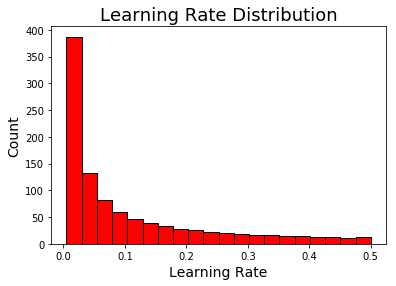

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Learning rate histogram
plt.hist(param_grid['learning_rate'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

### Learning Rate Domain

The learning rate domain is from 0.005 to 0.5. Using a logarithmic uniform distribution allows us to create a domain where there are as many values from 0.005 to 0.05 as from 0.05 to 0.5. In a linear space, there would be far more values from 0.05 to 0.5 because this represents a larger distance in linear space but in logarithmic space each of these two intervals is the same width because they are multiples of 10 of each other. (Think about going from 1 to 10 and then from 10 to 100. On a logarithmic scale, these intervals are the same size, but on a linear scale the latter is 10 times the size of the former). In other words, a logarithmic uniform distribution lets us sample more evenly from a domain that varies over several orders of magnitude. 

If that's a little confusing, perhaps the graph above makes it clearer. We can also do a sanity check to make sure the spacing is correct by counting the number of values in each interval.

In [15]:
a = 0
b = 0

# Check number of values in each category
for x in param_grid['learning_rate']:
    # Check values
    if x >= 0.005 and x < 0.05:
        a += 1
    elif x >= 0.05 and x < 0.5:
        b += 1

print('There are {} values between 0.005 and 0.05'.format(a))
print('There are {} values between 0.05 and 0.5'.format(b))

There are 499 values between 0.005 and 0.05
There are 499 values between 0.05 and 0.5


As an example of a simple domain, the `num_leaves` is a uniform distribution. This means values are evenly spaced on a linear scale.

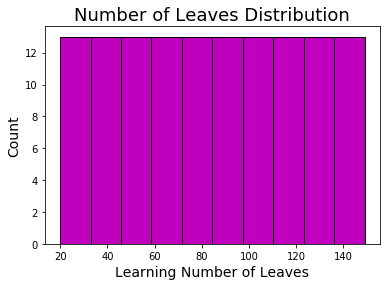

In [16]:
# number of leaves domain
plt.hist(param_grid['num_leaves'], color = 'm', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); plt.ylabel('Count', size = 14); plt.title('Number of Leaves Distribution', size = 18);

# Algorithm for selecting next values

Although we don't generally think of them as such, both grid and random search are algorithms. In the case of grid search, we input the domain and the algorithm selects the next value for each hyperparameter in an ordered sequence. The only requirement of grid search is that it tries every combination in a grid once (and only once). For random search, we input the domain and each time the algorithm gives us a random combination of hyperparameter values to try. There are no requirements for random search other than that the next values are selected at random. 

We will implement these algorithms very shortly, as soon as we cover the final part of hyperparameter tuning.

# Results History

The results history is a data structure that contains the hyperparameter combinations and the resulting score on the objective function. When we get to Bayesian Optimization, the model actually _uses the past results to decide on the next hyperparmeters_ to evaluate. Random and grid search are _uninformed_ methods that do not use the past history, but we still need the history so we can find out which hyperparameters worked the best! 

A dataframe is a useful data structure to hold the results.

In [17]:
# Dataframes for random and grid search
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

# Grid Search Implementation

Grid search is best described as exhuastive guess and check. We have a problem: find the hyperparameters that result in the best cross validation score, and a set of values to try in the hyperparameter grid - the domain. The grid search method for finding the answer is to try all combinations of values in the domain and hope that the best combination is  in the grid (in reality, we will never know if we found the best settings unless we have an infinite hyperparameter grid which would then require an infinite amount of time to run).

Grid search suffers from one limiting problem: it is extremely computationally expensive because we have to perform cross validation with every single combination of hyperparameters in the grid! Let's see how many total hyperparameter settings there are in our simple little grid we developed.

In [18]:
com = 1
for x in param_grid.values():
    com *= len(x)
print('There are {} combinations'.format(com))

There are 2620800000000000 combinations


Until Kaggle upgrades the kernels to quantum computers, we are not going to be able to run evan a fraction of the combinations! Let's assume 100 seconds per evaluation and see how many years this would take:

In [19]:
print('This would take {:.0f} years to finish.'.format((100 * com) / (60 * 60 * 24 * 365)))

This would take 8310502283 years to finish.


I think we're going to need a better approach! Before we discuss alternatives, let's walk through how we would actually use this grid and evaluate all the hyperparameters.

The code below shows the "algorithm" for grid search. First, we [unpack the values](https://www.geeksforgeeks.org/packing-and-unpacking-arguments-in-python/) in the hyperparameter grid (which is a Python dictionary) using the line `keys, values = zip(*param_grid.items())`.  The key line is `for v in itertools.product(*values)` where we iterate through all the possible combinations of values in the hyperparameter grid one at a time.  For each combination of values, we create a dictionary `hyperparameters = dict(zip(keys, v))` and then pass these to the objective function defined earlier. The objective function returns the cross validation score from the hyperparameters which we record in the dataframe. This process is repeated for each and every combination of hyperparameter values. By using `itertools.product` (from [this Stack Overflow Question and Answer](https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists)), we create a [generator](http://book.pythontips.com/en/latest/generators.html) rather than allocating a list of all possible combinations which would be far too large to hold in memory. 

In [20]:
import itertools

def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

Normally, in grid search, we do not limit the number of evaluations. The number of evaluations is set by the total combinations in the hyperparameter grid (or the number of years we are willing to wait!). So the lines 

```
        if i > MAX_EVALS:
            break
```

would not be used in actual grid search. Here we will run grid search for 5 iterations just as an example. The results returned will show us the validation score (ROC AUC), the hyperparameters, and the iteration sorted by best performing combination of hyperparameter values.

In [21]:
grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

The best validation score was 0.71957

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': True,
 'learning_rate': 0.004999999999999999,
 'metric': 'auc',
 'min_child_samples': 20,
 'n_estimators': 132,
 'num_leaves': 20,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.5,
 'subsample_for_bin': 20000,
 'verbose': 1}


Now, since we have the best hyperparameters, we can evaluate them on our "test" data (remember not the real test data)!

In [22]:
# Get the best parameters
grid_search_params = grid_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**grid_search_params, random_state=42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from grid search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

The best model from grid search scores 0.72694 ROC AUC on the test set.


It's interesting that the model scores better on the test set than in cross validation. Usually the opposite happens (higher on cross validation than on test) because the model is tuned to the validation data. In this case, the better performance is probably due to small size of the test data and we get very lucky (although this probably does not translate to the actual competition data). 

To get a sense of how grid search works, we can look at the progression of hyperparameters that were evaluated.

In [23]:
pd.options.display.max_colwidth = 1000
grid_results['params'].values

array([{'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 132},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 132},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5050505050505051, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 132},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 

Look at the `subsample` and the `is_unbalance` because these are the only hyperparameters that change. In fact, the effect of  changing these values is so small that validation scores literally did not change across runs (indicating this small of a change has no effect on the model). This is grid search trying every single value in the grid! No matter how small the increment between subsequent values of a hyperparameter, it will try them all. Clearly, we are going to need a more efficient approach if we want to find better hyperparameters in a reasonable amount of time. 

#### Application

If you want to run this on the entire dataset feel free to take these functions and put them in a script. However, I would advise against using grid search unless you have a very small hyperparameter grid because this is such as exhaustive method! 
Later, we will look at results from 1000 iterations of grid and random search run on the same small subset of data as we used above. I have not tried to run any form of grid search on the full data (and probably will not try this method).

# Random Search

Random search is surprisingly efficient compared to grid search. Although grid search will find the optimal value of hyperparameters (assuming they are in your grid) eventually, random search will usually find a "close-enough" value in far fewer iterations. [This great paper explains why this is so](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf): grid search spends too much time evaluating unpromising regions of the hyperparameter search space because it has to evaluate every single combination in the grid. Random search in contrast, does a better job of exploring the search space and therefore can usually find a good combination of hyperparameters in far fewer iterations. 

As [this article](https://medium.com/rants-on-machine-learning/smarter-parameter-sweeps-or-why-grid-search-is-plain-stupid-c17d97a0e881) lays out, random search should probably be the first hyperparameter optimization method tried because of its effectiveness. Even though it's an _uninformed_ method (meaning it does not rely on past evaluation results), random search can still usually find better values than the default and is simple to run.

Random search can also be thought of as an algorithm: randomly select the next set of hyperparameters from the grid! We can build a dictionary of hyperparameters by selecting one random value for each hyperparameter as follows (again accounting for subsampling):

In [24]:
random.seed(50)

# Randomly sample from dictionary
random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
# Deal with subsample ratio
random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

random_params

{'boosting_type': 'goss',
 'colsample_bytree': 0.8222222222222222,
 'is_unbalance': False,
 'learning_rate': 0.027778881111994384,
 'min_child_samples': 175,
 'num_leaves': 88,
 'reg_alpha': 0.8979591836734693,
 'reg_lambda': 0.6122448979591836,
 'subsample': 1.0,
 'subsample_for_bin': 220000}

Next, we define the `random_search` function. This takes the same general structure as `grid_search` except for the method used to select the next hyperparameter values. Moreover, random search is always run with a limit on the number of search iterations.

In [25]:
def random_search(param_grid, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [26]:
random_results = random_search(param_grid)

print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(random_results.loc[0, 'params'])

The best validation score was 0.72420

The best hyperparameters were:
{'boosting_type': 'dart',
 'colsample_bytree': 0.9555555555555555,
 'is_unbalance': True,
 'learning_rate': 0.2797162853084688,
 'metric': 'auc',
 'min_child_samples': 365,
 'n_estimators': 16,
 'num_leaves': 50,
 'reg_alpha': 0.6326530612244897,
 'reg_lambda': 0.5510204081632653,
 'subsample': 0.8434343434343434,
 'subsample_for_bin': 220000,
 'verbose': 1}


We can also evaluate the best random search model on the "test" data.

In [27]:
# Get the best parameters
random_search_params = random_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**random_search_params, random_state = 42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from random search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

The best model from random search scores 0.71347 ROC AUC on the test set.


Finally, we can view the random search sequence of hyperparameters.

In [28]:
random_results['params']

0        {'boosting_type': 'dart', 'num_leaves': 50, 'learning_rate': 0.2797162853084688, 'subsample_for_bin': 220000, 'min_child_samples': 365, 'reg_alpha': 0.6326530612244897, 'reg_lambda': 0.5510204081632653, 'colsample_bytree': 0.9555555555555555, 'subsample': 0.8434343434343434, 'is_unbalance': True, 'metric': 'auc', 'verbose': 1, 'n_estimators': 16}
1     {'boosting_type': 'gbdt', 'num_leaves': 104, 'learning_rate': 0.08633904519421778, 'subsample_for_bin': 200000, 'min_child_samples': 290, 'reg_alpha': 0.8163265306122448, 'reg_lambda': 0.1020408163265306, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.9444444444444444, 'is_unbalance': False, 'metric': 'auc', 'verbose': 1, 'n_estimators': 41}
2    {'boosting_type': 'dart', 'num_leaves': 130, 'learning_rate': 0.005116582891651224, 'subsample_for_bin': 80000, 'min_child_samples': 235, 'reg_alpha': 0.3469387755102041, 'reg_lambda': 0.5510204081632653, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.6262626262626263, '

This time we see hyperparameter values that are all over the place, almost as if they had been selected at random! Random search will do a much better job than grid search of exploring the search domain (for the same number of iterations). If we have a limited time to evaluate hyperparameters, random search is a better option than grid search for exactly this reason.

### Stacking Random and Grid Search

One option for a smarter implementation of hyperparameter tuning is to combine random search and grid search: 

1. Use random search with  a large hyperparameter grid 
2. Use the results of random search to build a focused hyperparameter grid around the best performing hyperparameter values.
3. Run grid search on the reduced hyperparameter grid. 
4. Repeat grid search on more focused grids until maximum computational/time budget is exceeded.

In a later notebook (upcoming), we will look at methods that use the past evaluation results to pick the next hyperparameter values to try in the objective function. These methods (including [Bayesian optimization](https://sigopt.com/static/pdf/SigOpt_Bayesian_Optimization_Primer.pdf)) are essentially doing what we would do in the strategy outlined above: adjust the next values tried in the search from the previous results. The overall objective of these _informed methods_ is to limit evaluations of the objective function by reasoning about the next values to try based on past evaluation results. These algorithms are therefore able to save time by evaluating more promising values of hyperparameters. This is a really cool topic and [Bayesian optimization](http://gpss.cc/gpmc17/slides/LancasterMasterclass_1.pdf) is fascinating so stay tuned for this upcoming notebook. 

## Next Steps

We can now take these random and grid search functions and use them on the complete dataset or any dataset of our choosing. These search methods are very expensive, so expect the hyperparameter tuning to take a while.(I am currently running this script on a full set of features for 500 iterations and will make the results public when they are available. )

For now, we will turn to implementing random and grid search on the reduced dataset for 1000 iterations just to compare the results (I took the code below and already ran it because even with the small dataset, it takes a very long time. The results are available as part of the data in this kernel). 

## Writing to File to Monitor Progress

When we run these searches for a long time, it's natural to want to track the performance while the search is going on. We can print information to the command prompt, but this will grow cluttered after 1000 iterations and the results will be gone if we close the command prompt. A better solution (although not perfect) is to write a line to a csv (comma separated value) file on each iteration. Then, we can look at the file to track progress while the searching is running, and eventually, have the entire results saved when the search is complete.

### Extremely Important Note about Checking Files

When you want to check the csv file, __do not open it in Excel while the search is ongoing__. This will cause a permission error in Python and the search will be terminated. Instead, you can view the end of the file by typing `tail out_file.csv` from Bash where `out_file.csv` is the name of the file being written to. There are also some text editors, such as notepad or Sublime Text, where you can open the results safely while the search is occurring. However, __do not use Excel to open a file that is being written to in Python__. This is a mistake I've made several times so you do not have to! 

Below is the code we need to run before the search. This creates the csv file, opens a connection, writes the header (column names), and then closes the connection. This will overwrite any information currently in the `out_file`, so change to a new file name every time you want to start a new search.

In [29]:
import csv

# Create file and open connection
out_file = 'random_search_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

Now we must slightly modify `random_search` and `grid_search` to write to this file every time. We do this by opening a connection, this time using the `"a"` option for append (the first time we used the `"w"` option for write) and writing a line with the desired information (which in this case is the cross validation score, the hyperparameters, and the number of the iteration). Then we close the connection until the function is called again.

In [30]:
def random_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization. 
       Writes result of search to csv file every search iteration."""
    
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(random_params, i)
        results.loc[i, :] = eval_results

        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)

    return results 

In [31]:
def grid_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)
       Writes result of search to csv file every search iteration."""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        # Select the hyperparameters
        parameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        parameters['subsample'] = 1.0 if parameters['boosting_type'] == 'goss' else parameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(parameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

To run these functions for 1000 iterations (or however many you choose) uncomment the cell below. Otherwise, I have run these functions on the reduced dataset and attached the results to this kernel.

In [32]:
# MAX_EVALS = 1000

# # Create file and open connection
# out_file = 'grid_search_trials_1000.csv'
# of_connection = open(out_file, 'w')
# writer = csv.writer(of_connection)

# # Write column names
# headers = ['score', 'hyperparameters', 'iteration']
# writer.writerow(headers)
# of_connection.close()

# grid_results = grid_search(param_grid, out_file)


# # Create file and open connection
# out_file = 'random_search_trials_1000.csv'
# of_connection = open(out_file, 'w')
# writer = csv.writer(of_connection)

# # Write column names
# headers = ['score', 'hyperparameters', 'iteration']
# writer.writerow(headers)
# of_connection.close()

# random_results = random_search(param_grid, out_file)

# Results on Limited Data

We can examine 1000 search iterations of the above functions on the reduced dataset. Later, we can try the hyperparameters that worked the best for the small versions of the data on a complete dataset to see if the best hyperparameters translate when increasing the size of the data 30 times! The 1000 search iterations were not run in a kernel, although they might be able to finish (no guarantees) in the 12 hour time limit. 

First we can find out which method returned the best results. 

In [33]:
random_results = pd.read_csv('../input/home-credit-model-tuning/random_search_trials_1000.csv')
grid_results = pd.read_csv('../input/home-credit-model-tuning/grid_search_trials_1000.csv')

When we save the results to a csv, for some reason the dictionaries are saved as strings. Therefore we need to convert them back to dictionaries after reading in the results using the `ast.literal_eval` function.

In [34]:
import ast

# Convert strings to dictionaries
grid_results['hyperparameters'] = grid_results['hyperparameters'].map(ast.literal_eval)
random_results['hyperparameters'] = random_results['hyperparameters'].map(ast.literal_eval)

Now let's make a function to parse the results from the hyperparameter searches. This returns a dataframe where each column is a hyperparameter and each row has one search result (so taking the dictionary of hyperparameters and mapping it into a row in a dataframe).

In [35]:
def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
        
    # Sort with best values on top
    results = results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, results.loc[0, 'score'], results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = results['iteration']
    hyp_df['score'] = results['score']
    
    return hyp_df

In [36]:
grid_hyp = evaluate(grid_results, name = 'grid search')

The highest cross validation score from grid search was 0.73110 found on iteration 996.
ROC AUC from grid search on test data = 0.73274.


In [37]:
random_hyp = evaluate(random_results, name = 'random search')

The highest cross validation score from random search was 0.73448 found on iteration 596.
ROC AUC from random search on test data = 0.73069.


# Visualizations

Visualizations are both enjoyable to make, and can give us an intuitive look into a technique. Here we will make a few simple plots using matplotlib, seaborn, and Altair! __Unfortunately, the Altair visualizations do not show up when the notebook is rendered. To view the Altair figures, you'll have to run the notebook yourself!__

First we can plot the validation scores versus the iteration. Here we will use the [Altair](https://altair-viz.github.io/) visualization library to make some plots! First, we need to put our data into a long format dataframe.

In [38]:
import altair as alt

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [39]:
# Combine results into one dataframe
random_hyp['search'] = 'random'
grid_hyp['search'] = 'grid'

hyp = random_hyp.append(grid_hyp)
hyp.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,boosting_type,colsample_bytree,is_unbalance,iteration,learning_rate,metric,min_child_samples,n_estimators,num_leaves,reg_alpha,reg_lambda,score,search,subsample,subsample_for_bin,verbose
0,gbdt,0.644444,True,596,0.070164,auc,390,73,86,0.959184,0.673469,0.734484,random,0.530303,220000,1
1,gbdt,0.688889,False,292,0.019035,auc,360,210,146,0.061224,0.612245,0.734312,random,0.848485,240000,1
2,dart,0.600000,True,281,0.075188,auc,430,133,65,0.959184,0.489796,0.734079,random,0.757576,20000,1
3,dart,0.688889,True,349,0.055464,auc,485,375,102,0.571429,0.408163,0.734025,random,0.550505,120000,1
4,gbdt,0.600000,False,538,0.032492,auc,395,133,29,0.326531,0.061224,0.733680,random,0.898990,260000,1


In [40]:
max_random = random_hyp['score'].max()
max_grid = grid_hyp['score'].max()

c = alt.Chart(hyp, width = 400, height = 400).mark_circle(size = 150).encode(alt.Y('score', scale = alt.Scale(domain = [0.65, 0.76])),
x = 'iteration', color = 'search')

c.title = 'Score vs Iteration'
c

Below, we make the same plot using seaborn because the Altair visualizations do not show up in the rendered notebook. 

In [41]:
best_grid_hyp = grid_hyp.iloc[grid_hyp['score'].idxmax()].copy()
best_random_hyp = random_hyp.iloc[random_hyp['score'].idxmax()].copy()

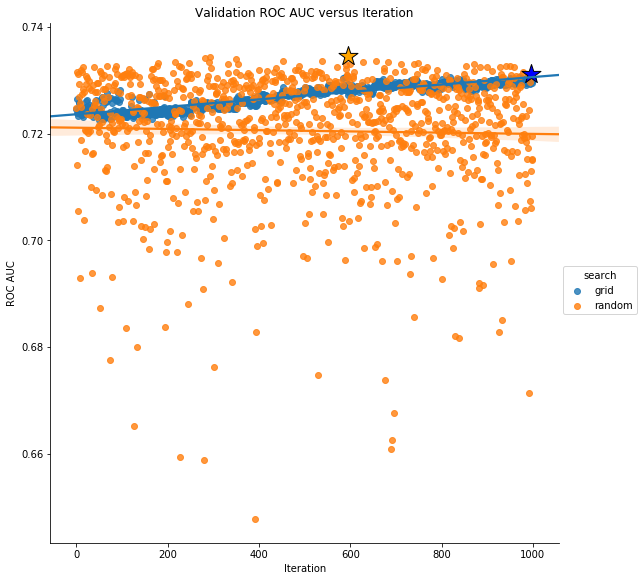

In [42]:

hyp.sort_values('search', inplace = True)

# Plot of scores over the course of searching
sns.lmplot('iteration', 'score', hue = 'search', data = hyp, size = 8);
plt.scatter(best_grid_hyp['iteration'], best_grid_hyp['score'], marker = '*', s = 400, c = 'blue', edgecolor = 'k')
plt.scatter(best_random_hyp['iteration'], best_random_hyp['score'], marker = '*', s = 400, c = 'orange', edgecolor = 'k')
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("Validation ROC AUC versus Iteration");

In [43]:
print('Average validation score of grid search =   {:.5f}.'.format(np.mean(grid_hyp['score'])))
print('Average validation score of random search = {:.5f}.'.format(np.mean(random_hyp['score'])))

Average validation score of grid search =   0.72712.
Average validation score of random search = 0.72054.


The grid cross validation score increases over time. This indicates that whatever hyperparameters are changing in grid search are gradually increasing the score. The random cross validation scores on the other hand are all over the place as expected. This grid search appears to be stuck in a relatively low-performing region of the search space, and because it is constrained to try all the values in the grid, it is not able to try significantly different hyperparameter values that would perform better (as occurs in random search). The random search method does a very good job of exploring the search space as we will see when we look at the hyperparameter values searched. 

## Distribution of Search Values

We can show the distribution of search values for random search (grid search is very uninteresting). Even though we expect these to be _random_, it's always a good idea to check our code both quantitatively and visually. 

In [44]:
# Create bar chart
bars = alt.Chart(random_hyp, width = 400).mark_bar().encode(x = 'boosting_type', y = alt.Y('count()', scale = alt.Scale(domain = [0, 400])))

bars.title = 'Boosting Type for Random Search'

# Add text for labels
text = bars.mark_text(align = 'center', baseline = 'bottom', size = 20).encode(text = 'count()')

# Display
bars + text

The boosting type should be evenly distributed for random search. 

Again, we have to remake this chart in seaborn to have the visualization appear in the rendered notebook (if anyone knows how to address this issue, please tell me in the comments!)

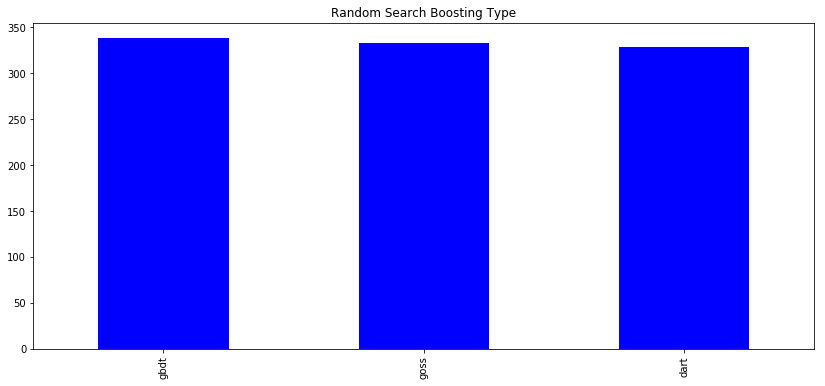

In [45]:
# Bar plots of boosting type
random_hyp['boosting_type'].value_counts().plot.bar(figsize = (14, 6), color = 'blue', title = 'Random Search Boosting Type');

Next, for the numeric hyperparameters, we will plot both the sampling distribution (the hyperparameter grid) and the results from random search in a kernel density estimate (KDE) plot. (The grid search results are completely uninteresting). As random search is just drawing random values, we would expect the random search distribution to align with the sampling grid (although it won't be perfectly aligned because of the limited number of searches). 

As an example, below we plot the distribution of learning rates from both the sampling distribution and the random search results. The vertical dashed line indicates the optimal value found from random search.

In [46]:
random_hyp['score'] = random_hyp['score'].astype(float)
best_random_hyp = random_hyp.loc[0, :].copy()

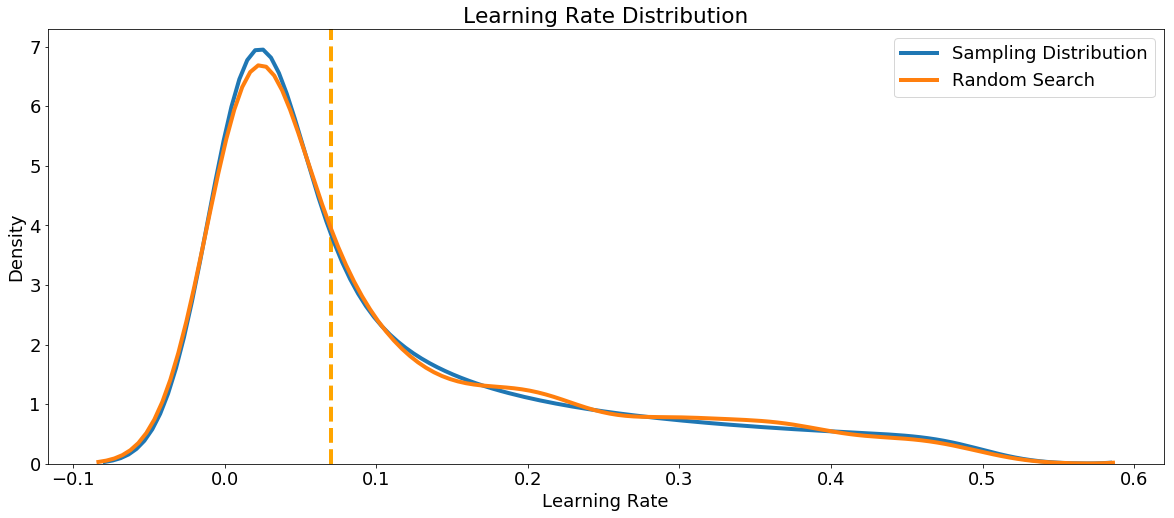

In [47]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(param_grid['learning_rate'], label = 'Sampling Distribution', linewidth = 4)
sns.kdeplot(random_hyp['learning_rate'], label = 'Random Search', linewidth = 4)
plt.vlines([best_random_hyp['learning_rate']],
           ymin = 0.0, ymax = 50.0, linestyles = '--', linewidth = 4, colors = ['orange'])
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

The following code repeats this plot for all the of the numeric hyperparameters. 

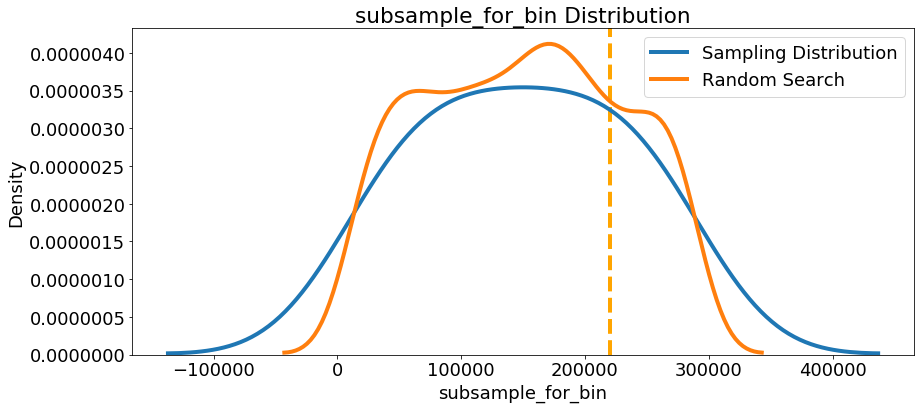

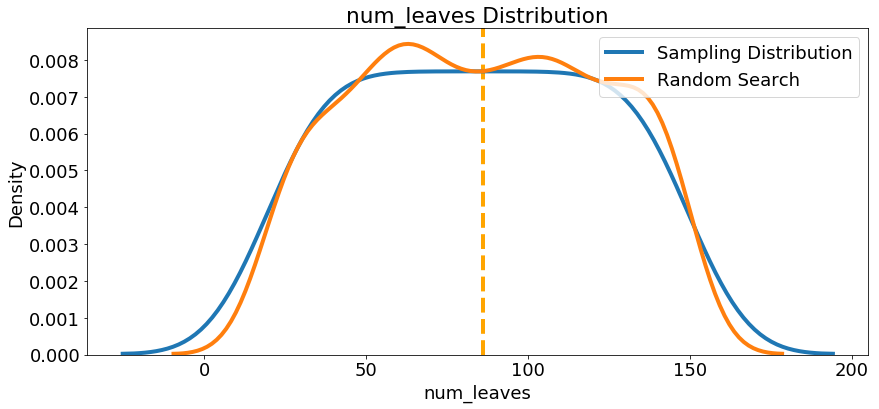

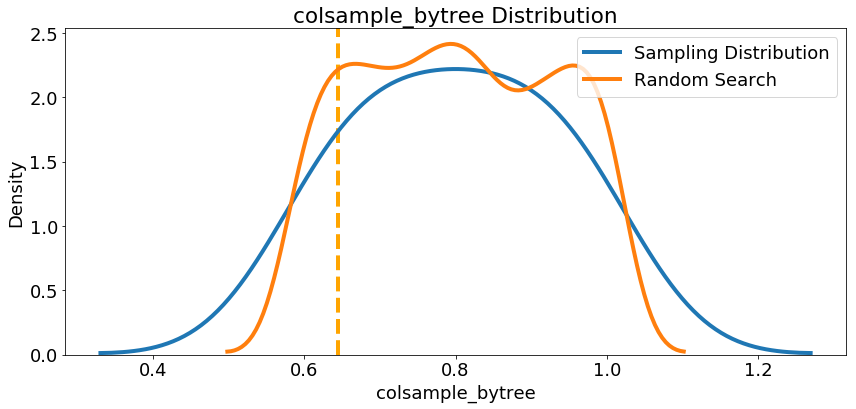

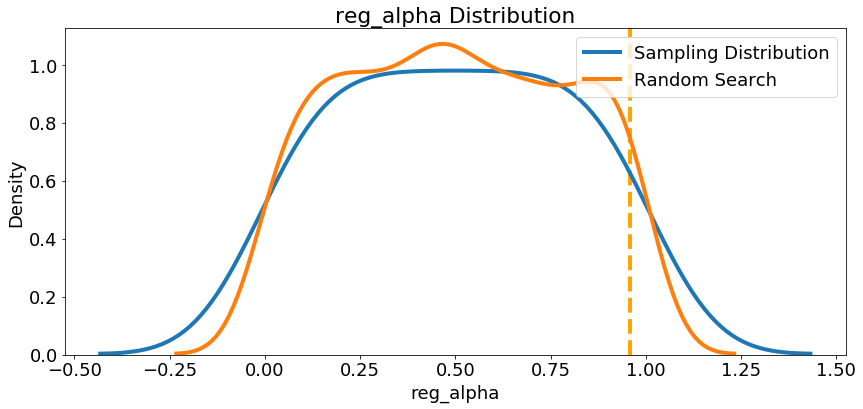

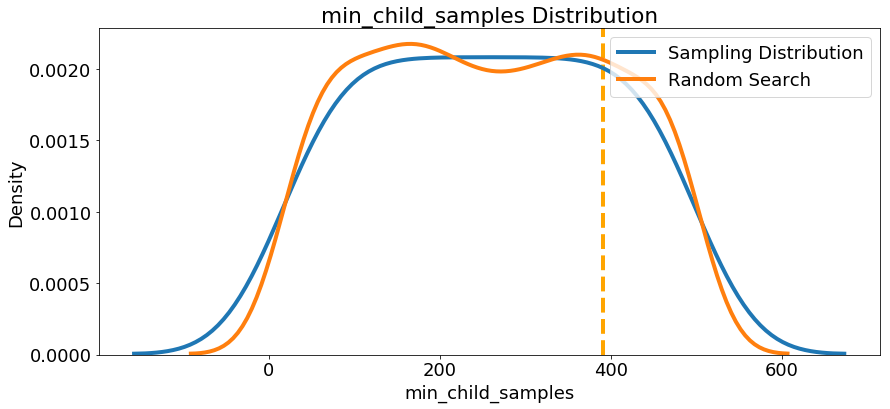

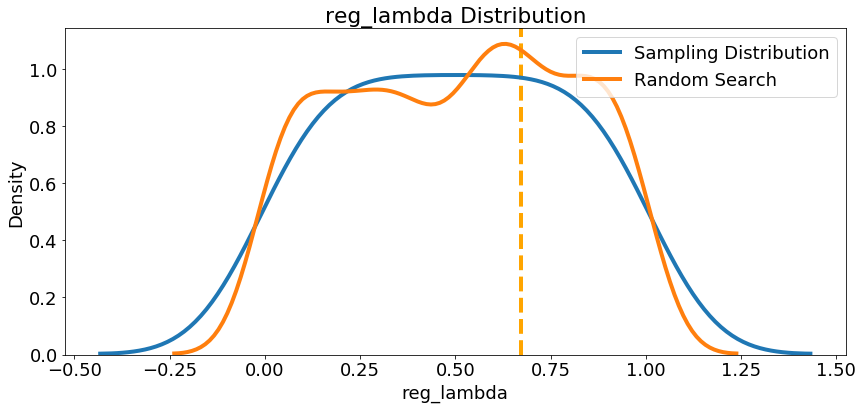

In [48]:
# Iterate through each hyperparameter
for i, hyper in enumerate(random_hyp.columns):
    if hyper not in ['boosting_type', 'iteration', 'subsample', 'score', 'learning_rate', 'is_unbalance', 'metric', 'verbose', 'iteration', 'n_estimators', 'search']:
        plt.figure(figsize = (14, 6))
        
        # Plot the random search distribution and the sampling distribution
        if hyper != 'loss':
            sns.kdeplot(param_grid[hyper], label = 'Sampling Distribution', linewidth = 4)
        sns.kdeplot(random_hyp[hyper], label = 'Random Search', linewidth = 4)
        plt.vlines([best_random_hyp[hyper]],
                     ymin = 0.0, ymax = 10.0, linestyles = '--', linewidth = 4, colors = ['orange'])
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();

## Sequence of Search Values

Finally, we can plot the sequence of search values against the iteration for random search. Clearly there will not be any order, but this can let us visualize what happens in a random search!

The star indicates the best value of the hyperparameter that was found.

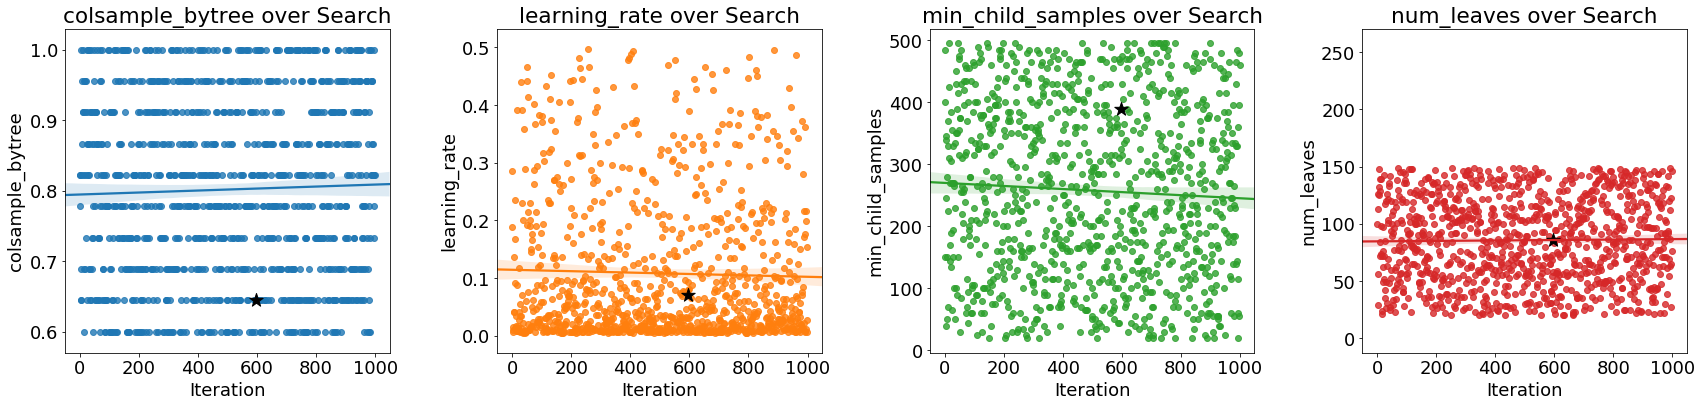

In [49]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
        random_hyp[hyper] = random_hyp[hyper].astype(float)
        # Scatterplot
        sns.regplot('iteration', hyper, data = random_hyp, ax = axs[i])
        axs[i].scatter(best_random_hyp['iteration'], best_random_hyp[hyper], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

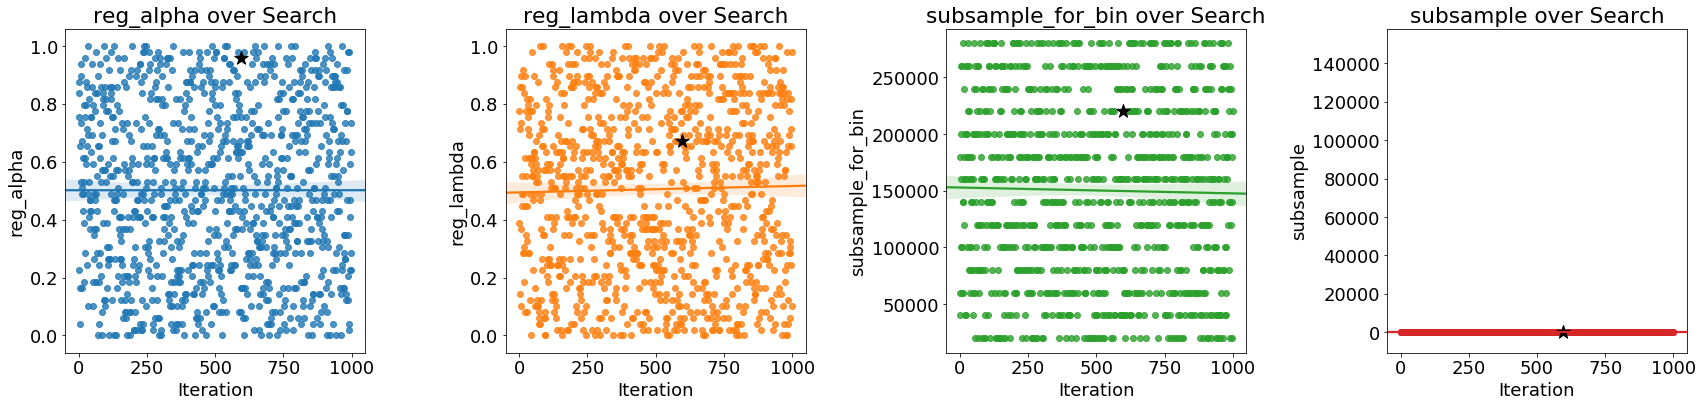

In [50]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Scatterplot of next four hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin', 'subsample']):
        random_hyp[hyper] = random_hyp[hyper].astype(float)
        sns.regplot('iteration', hyper, data = random_hyp, ax = axs[i])
        axs[i].scatter(best_random_hyp['iteration'], best_random_hyp[hyper], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

## Score versus Hyperparameters

As a final plot, we can show the score versus the value of each hyperparameter. We need to keep in mind that the hyperparameters are not changed one at a time, so if there are relationships between the values and the score, they do not mean that particular hyperparameter is influencing the score. However, we might be able to identify values of hyperparameters that seem more promising. Mostly these plots are for my own interest, to see if there are any trends! 

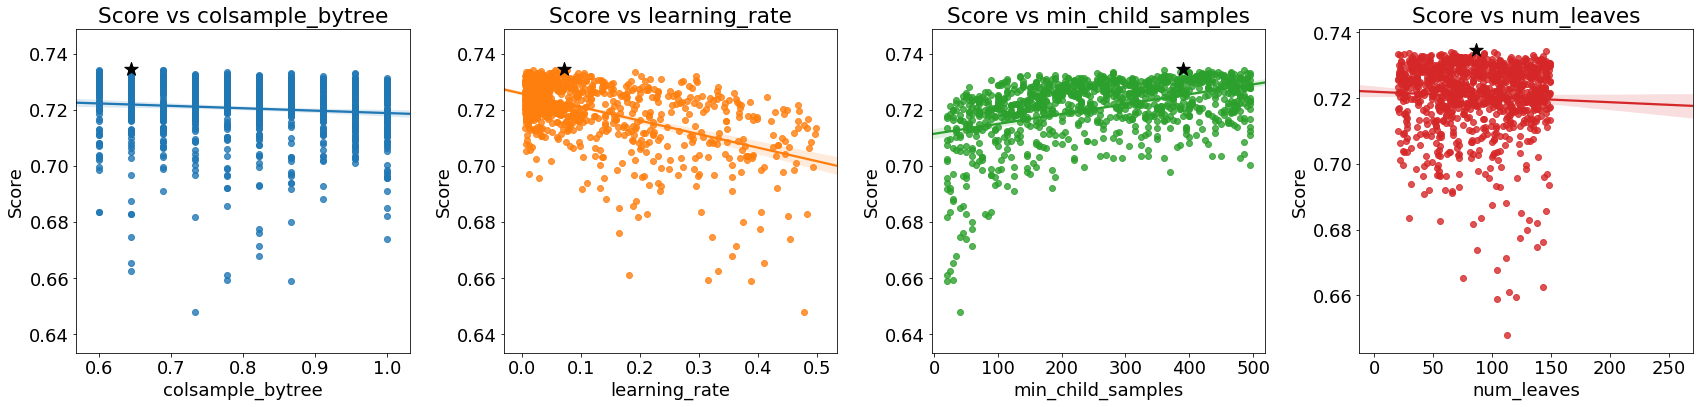

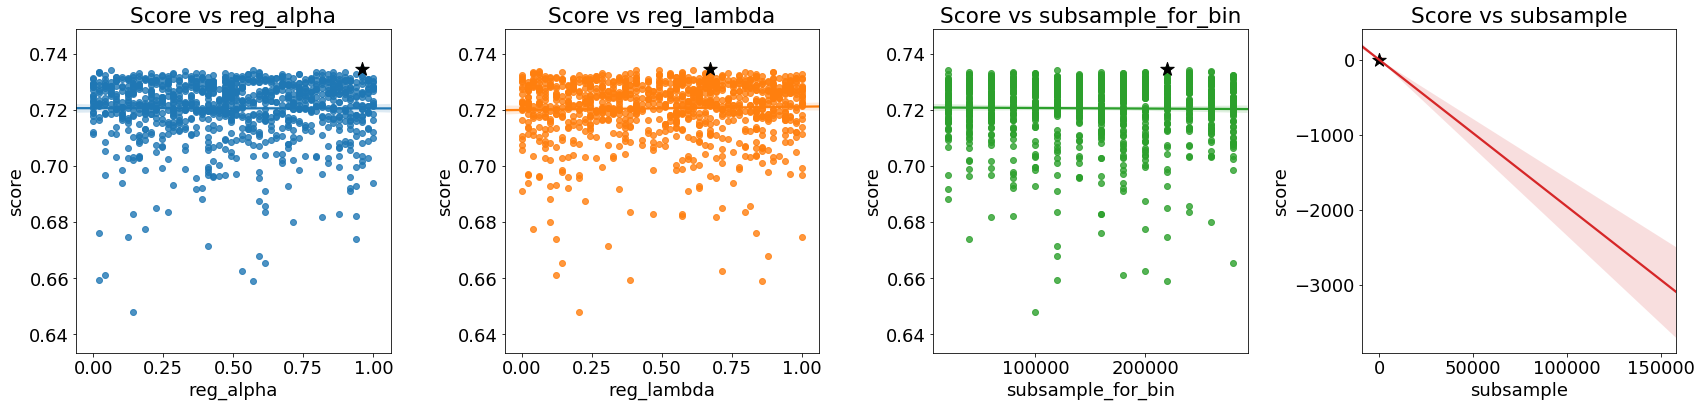

In [51]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
        random_hyp[hyper] = random_hyp[hyper].astype(float)
        # Scatterplot
        sns.regplot(hyper, 'score', data = random_hyp, ax = axs[i])
        axs[i].scatter(best_random_hyp[hyper], best_random_hyp['score'], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = '{}'.format(hyper), ylabel = 'Score', title = 'Score vs {}'.format(hyper));

plt.tight_layout()

fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Scatterplot of next four hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin', 'subsample']):
        random_hyp[hyper] = random_hyp[hyper].astype(float)
        sns.regplot(hyper, 'score', data = random_hyp, ax = axs[i])
        axs[i].scatter(best_random_hyp[hyper], best_random_hyp['score'], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = '{}'.format(hyper), ylabel = 'score', title = 'Score vs {}'.format(hyper));

plt.tight_layout()

We want to avoid placing too much emphasis on any of these relationships because we were not changing one hyperparameter at a time (although we could carry out experiments where we only change one hyperparameter and observes the effects on the score) and so the trends are not due solely to the single hyperparameter we show. If we could plot this in higher dimensions, it might be interesting to see if there are more promising regions of the search space but here we are limited to one dimension (a single hyperparameter versus the score).  If we want to observe the effects of one hyperparameter on the cross validation score, we could alter only that hyperparameter while holding all the others constant. However, the hyperparameters do not act by themselves and there are complex interactions between the model settings.

# Testing Results on Full Data

We can take the best hyperparameters found from the 1000 iterations of random search on the reduced training data and try these on an entire training dataset. Here, we will use the features from the `[Updated 0.792 LB] LightGBM with Simple Features
`(https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) kernel (I did not develop these features and want to give credit to the numerous people, including [Aguiar](https://www.kaggle.com/jsaguiar) and [olivier](https://www.kaggle.com/ogrellier),  who have worked on these features. Please check out their [kernels](https://www.kaggle.com/ogrellier/lighgbm-with-selected-features)!). 

The code below uses the best random search hyperparameters to build a model, train on the full features from `[Updated 0.792 LB] LightGBM with Simple Features
`(https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features), and test on the testing features. The test data is the actual competition data, so we can then submit these and see how well the score translates to a full dataset! 

In [52]:
# Read in full dataset
train = pd.read_csv('../input/home-credit-simple-featuers/simple_features_train.csv')
test = pd.read_csv('../input/home-credit-simple-featuers/simple_features_test.csv')

# Extract the test ids and train labels
test_ids = test['SK_ID_CURR']
train_labels = np.array(train['TARGET'].astype(np.int32)).reshape((-1, ))

train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])
test = test.drop(columns = ['SK_ID_CURR'])

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307507, 718)
Testing shape:  (48744, 718)


First we will test the cross validation score using the best model hyperparameter values from random search. This can give us an idea of the generalization error on the test set. We will delete the number of estimators found from the smaller dataset and use early stopping to find the best number of decision trees to train. 

In [53]:
train_set = lgb.Dataset(train, label = train_labels)

hyperparameters = dict(**random_results.loc[0, 'hyperparameters'])
del hyperparameters['n_estimators']

# Cross validation with n_folds and early stopping
cv_results = lgb.cv(hyperparameters, train_set,
                    num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS)

In [54]:
print('The cross validation score on the full dataset = {:.5f} with std: {:.5f}.'.format(
    cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('Number of estimators = {}.'.format(len(cv_results['auc-mean'])))

The cross validation score on the full dataset = 0.77394 with std: 0.00206.
Number of estimators = 160.


The public leaderboard score is only calculated on 10% of the test data, so the cross validation score might actually give us a better idea of how the model will perform on the full test set. Usually we expect the cross validation score to be higher than on the testing data, but because of the small size of the testing data, this might be reversed for this problem.

Next, we will make predictions on the test data that can be submitted to the competition. 

In [55]:
# Train the model with the optimal number of estimators from early stopping
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), **hyperparameters)
model.fit(train, train_labels)
                        
# Predictions on the test data
preds = model.predict_proba(test)[:, 1]

In [56]:
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': preds})
submission.to_csv('submission_simple_features_random.csv', index = False)

The score when submitting to the test competition is __0.782__. The original score from the kernel where I got these features was 0.792, so we can conclude that the results from random search on the smaller dataset to not translate to a full dataset. I currently am running random search with 500 iterations on the full dataset, and will make those results publicly available when the search is complete! 

## Model Tuning Next Steps

From here, we might want to take the functions we wrote and apply them to a complete dataset. The results are likely to be different because we were only using a random subset of the training data. However, this will take much longer (300000+ observations instead of 10000). I'm currently running the random search on the full dataset from the Kernel referenced above, and will see how the results turn out. (Sampling some of the observations is not inherently negative, and it can help us get reasonable answers in a much shorter time frame. However, if we are using such a small portion of the data that is not representative of the entire dataset, then we should not expect the tuning to translate to the full dataset.)

In an upcoming notebook, we will turn to automated hyperparameter tuning, in particular, Bayesian Optimization. We will implement automated optimization of machine learning hyperparameters step-by-step using the Hyperopt open-source Python library. I'll provide the link here as soon as this notebook is finished, but if you want to get an idea of Bayesian optimization, you can check out [this introductory article](https://towardsdatascience.com/an-introductory-example-of-bayesian-optimization-in-python-with-hyperopt-aae40fff4ff0), or [this article on automated hyperparameter tuning](https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a). These topics are pretty neat and it's incredible that they are available in an easy-to-use format for anyone to take advantage of. I'll see you in the next notebook! 

# Conclusions

Model tuning is the process of finding the best machine learning model hyperparameters for a particular problem. Random and grid search are two uniformed methods for hyperparameter tuning that search by selecting hyperparameter values from a grid domain. 
The four parts of hyperparameter tuning are:

1. Objective function: takes in hyperparameters and returns the cross validation score we want to maximize or minimize
2. Domain of hyperparameters: values over which we want to search
3. Algorithm: method for selecting the next hyperparameter values to evaluate in the objective function
4. Results: history of hyperparameters and cross validation scores

These four parts apply to grid and random search as well as to Bayesian optimization, a form of automated hyperparameter tuning. In this notebook, we implemented both random and grid search on a reduced dataset, inspected the results, and tried to translate the optimal hyperparameters to a full dataset (from [this kernel](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features)). As a small note, it's important to remember that we tune the hyperparameters to the training data - using cross validation - so the hyperparameter values we find are only optimal for the training data. Although the best hyperparameters from the smaller dataset did not work that well on the full dataset, we were still able to see the ideas behind these two tuning methods. Moreover, we can take the functions developed here and apply them to any dataset or to any machine learning model, not just the gradient boosting machine. 

Random search turns out to work pretty well in practice (because it is good at exploring the search domain), but it still is not a reasoning method because it does not use past evaluation results to choose the next hyperparameter values. A better approach would be to use the past results to reason about the best values to try next in the objective function, especially because as we saw, evaluating the objective function is time-consuming! In future work, we will look at [implementing automated hyperparameter tuning](https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a) using Bayesian optimization. 

Hyperparameter tuning is a crucial part of the machine learning pipeline because the performance of a model can depend strongly on the choices of the hyperparameter values. Random and grid search are two decent methods to start tuning a model (at least they are better than manual tuning) and are important tools to have in the data science skillset. Thanks for reading and I'll see you in the next notebook!

As always, I welcome feedback and constructive criticism. I write for Towards Data Science at https://medium.com/@williamkoehrsen/ and can be reached on Twitter at https://twitter.com/koehrsen_will

Will